In [1]:
!git clone https://github.com/PedroOrtix/ID_Inpainter.git
%cd ID_Inpainter
!pip install -r requirements.txt -q
!pip install "jax[cuda12_pip]==0.4.23" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html -q

Cloning into 'ID_Inpainter'...
remote: Enumerating objects: 18, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 18 (delta 0), reused 15 (delta 0), pack-reused 0
Receiving objects: 100% (18/18), 708.04 KiB | 3.36 MiB/s, done.
/content/ID_Inpainter


In [1]:
%cd ID_Inpainter

/content/ID_Inpainter


In [37]:
from paddleocr import PaddleOCR
import numpy as np
import ocr
import PIL.Image as Image

#open a file containing the image
img = Image.open('images/imagen_dni.jpg')
img_array = np.array(img)

In [32]:
model = PaddleOCR(use_angle_cls=True, lang='es')  # 'es' para español
# Realiza OCR
result = model.ocr(img_array)
bounds = ocr.convert_paddle_to_easyocr(result)

[2024/08/10 16:51:29] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='/root/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='/root/.paddleocr/whl/rec/latin/latin_PP-OCRv3_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6, max_text_length=25,

In [ ]:
# Imprime los nombres (textos) de los cuadros delimitadores
for bound in bounds:
  print(bound[1])

In [44]:
#plot the image with the bounding boxes
# img = ocr.draw_boxes(img, result)
palabra = "02062031"
img_resized, coordenadas_originales = ocr.recortar_imagen(bounds, palabra, img_array, nueva_dimension=512)
img_pil = Image.fromarray(img_resized).convert('RGB')
img_pil.save("images/imagen_dni_recortada.jpg", )

# hacemos ocr de la imagen array ya recortada y redimensionada
bounds_resized = model.ocr(np.array(img_pil))
bounds_resized = ocr.convert_paddle_to_easyocr(bounds_resized)

[2024/08/10 16:59:18] ppocr DEBUG: dt_boxes num : 24, elapsed : 0.4621896743774414
[2024/08/10 16:59:19] ppocr DEBUG: cls num  : 24, elapsed : 0.10230779647827148
[2024/08/10 16:59:20] ppocr DEBUG: rec_res num  : 24, elapsed : 1.1586894989013672


In [47]:
from run import simple_inpaint

# reemplazamos la palabra en la imagen
replace = ["01 01 2059"]
right_bounds = [bound for bound in bounds_resized if bound[1] == palabra]

# hacer inpaint en la imagen
# imagen modificada y coordenadas de la palabra reemplazada
modified_images, composed_prompt = simple_inpaint(img_pil, right_bounds, replace)


[[[187.0, 305.0, 325.0, 305.0, 325.0, 326.0, 187.0, 326.0], '01 01 2059']]
Tokenizer: Added 2175 tokens
[info] Prompt:  | Keywords:  | Radio: 8 | Steps: 25 | Guidance: 2.5 | Natural: False
Global Stack: [[[187.0, 305.0, 325.0, 305.0, 325.0, 326.0, 187.0, 326.0], '01 01 2059']]
prompt   <|endoftext|><|startoftext|> l46.0 t76.0 r81.0 b81.0 [0] [1] [ ] [0] [1] [ ] [2] [0] [5] [9] <|endoftext|>
Composed Prompt: <|startoftext|><|endoftext|><|startoftext|> l46. 0 t76. 0 r81. 0 b81. 0 [0] [1] [ ] [0] [1] [ ] [2] [0] [5] [9] <|endoftext|><|endoftext|>
masked_feature.shape torch.Size([4, 4, 64, 64])


100%|██████████| 25/25 [00:15<00:00,  1.64it/s]


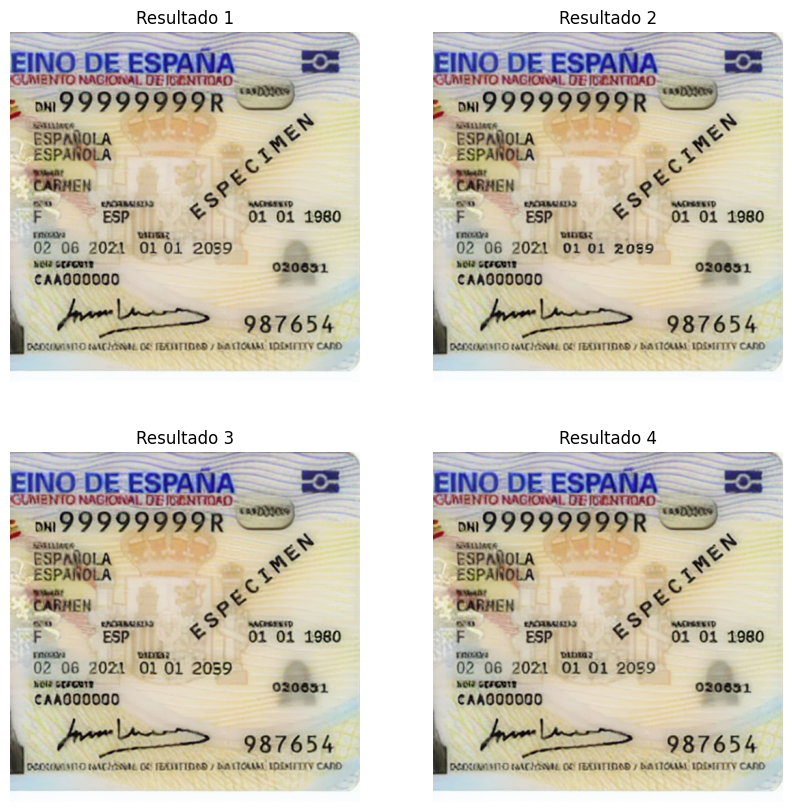

In [48]:
# Mostrar los 4 resultados en una cuadrícula
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
for i, ax in enumerate(axs.flatten()):
    ax.imshow(modified_images[i])
    ax.axis('off')
    ax.set_title(f"Resultado {i+1}")

In [49]:
modified_images[2].save("images/modified_image.jpg")

In [50]:
from PIL import Image
from ocr import comparar_imagenes

coodinates = np.array(right_bounds[0][0], dtype = int).flatten()
comparar_imagenes("images/modified_image.jpg", "images/imagen_dni_recortada.jpg", coodinates)


In [53]:
from PIL import Image
from ocr import reemplazar_parte_imagen

img_recortada_mod = reemplazar_parte_imagen("images/imagen_dni_recortada.jpg", "images/modified_image.jpg", coodinates)

In [57]:
# del one dim od the array
img_array = img_array[:, :, :3]
x_min, y_min, x_max, y_max = coordenadas_originales
img_array[y_min:y_max, x_min:x_max] = img_recortada_mod

In [58]:
Image.fromarray(img_array).save("images/resultado_final.jpg")